# Introduction

## 1. Importing Libraries

In [17]:
# General
import warnings
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, plot, iplot
from plotly.offline import init_notebook_mode
import cufflinks as cf

General set-up

In [18]:
%load_ext watermark
%watermark -i -v -u -co
init_notebook_mode(connected=True)
%matplotlib inline
# sns.set_style("white")
# plt.style.use("fast")
cf.go_offline()
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', '{:.4f}'.format)

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-08-24T08:30:52.598073+08:00

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.22.2

conda environment: data_analysis_31013



In [19]:
px.colors.cyclical.swatches()
px.colors.qualitative.swatches()
px.colors.sequential.swatches()

In [20]:
# Seeding random generator
np.random.seed(252)

## 2. Trip Distribution Methods

### a. Growth Factor methods

#### i. Average Factor method

In [21]:
def afm(present_trips, future_trips, growth_rate, afm_iteration):
    
    afm_iteration = afm_iteration
    present_trips = present_trips
    future_trips = future_trips
    growth_rate = growth_rate

    afm_growth_rate = np.zeros((growth_rate.shape[-2] * (afm_iteration + 1), growth_rate.shape[-1]))    # matrix for storing progression of growth rates, adding 1 in iteration to incorporate original data
    afm_array = np.zeros((present_trips.shape[-2] * (afm_iteration + 1), present_trips.shape[-1]))      # matrix for storing progression of present trips, adding 1 in iteration to incorporate original data
    afm_recharging_array = np.zeros((present_trips.shape[-2], present_trips.shape[-1]))     # dedicated mxn matrix to store trips that will be multiplied to averaged growth rate
    afm_recharging_growth_rate = np.zeros_like(afm_recharging_array, dtype=float)       # dedicated mxn matrix to store averaged growth rate

    for i in range(present_trips.shape[-2]):
        for j in range(present_trips.shape[-1]):

            for k in range(growth_rate.shape[-1]):
                afm_growth_rate[i, k] = growth_rate[i, k]       # 0th index (1st level) of trip growth rate matrix
            afm_array[i, j] = present_trips[i, j]       # 0th index (1st level) of present trip matrix


    for t in range(afm_iteration):
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                afm_recharging_growth_rate[i, j] = (afm_growth_rate[(present_trips.shape[-2] * t) + i, 0] +
                                                    afm_growth_rate[(present_trips.shape[-2] * t) + j, 1]) * 0.5  # not advanced
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                afm_recharging_array[i, j] = afm_array[(present_trips.shape[-2] * t) + i, j]  # not advanced             
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                afm_array[(present_trips.shape[-2] * (t + 1)) + i, j] = afm_recharging_array[i, j] * \
                                                                        afm_recharging_growth_rate[i, j]  # advanced, calculating the 1 + nth iteration row of future trips in afm_array
        new_recharging_array_sum = np.transpose(np.vstack(
            (
                afm_array[
                    (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                    0: (present_trips.shape[-1])
                    ].sum(axis=1),
                afm_array[
                    (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                    0: (present_trips.shape[-1])
                    ].sum(axis=0)
            )
        ))        
        new_recharging_growth_rate = future_trips / new_recharging_array_sum        
        for i in range(present_trips.shape[-2]):
            for j in range(growth_rate.shape[-1]):
                afm_growth_rate[(present_trips.shape[-2] * (t + 1)) + i, j] = new_recharging_growth_rate[i, j]  # advanced, calculating the 1 + nth iteration of growth rate in afm_growth_rate
    
    mock_convergence = np.ones((present_trips.shape[-2], afm_growth_rate.shape[-1]), dtype=float)       # base matrix for comparing convergence rate to 1 using 1 + nth iteration growth rate
    
    afm_convergence = afm_growth_rate[
        ((present_trips.shape[-2] * (afm_iteration + 1)) - present_trips.shape[-2]): present_trips.shape[-2] * (afm_iteration + 1),
        0: afm_growth_rate.shape[-1]
        ]
    
    return np.amax(np.absolute(afm_convergence - mock_convergence)) * 100

Testing

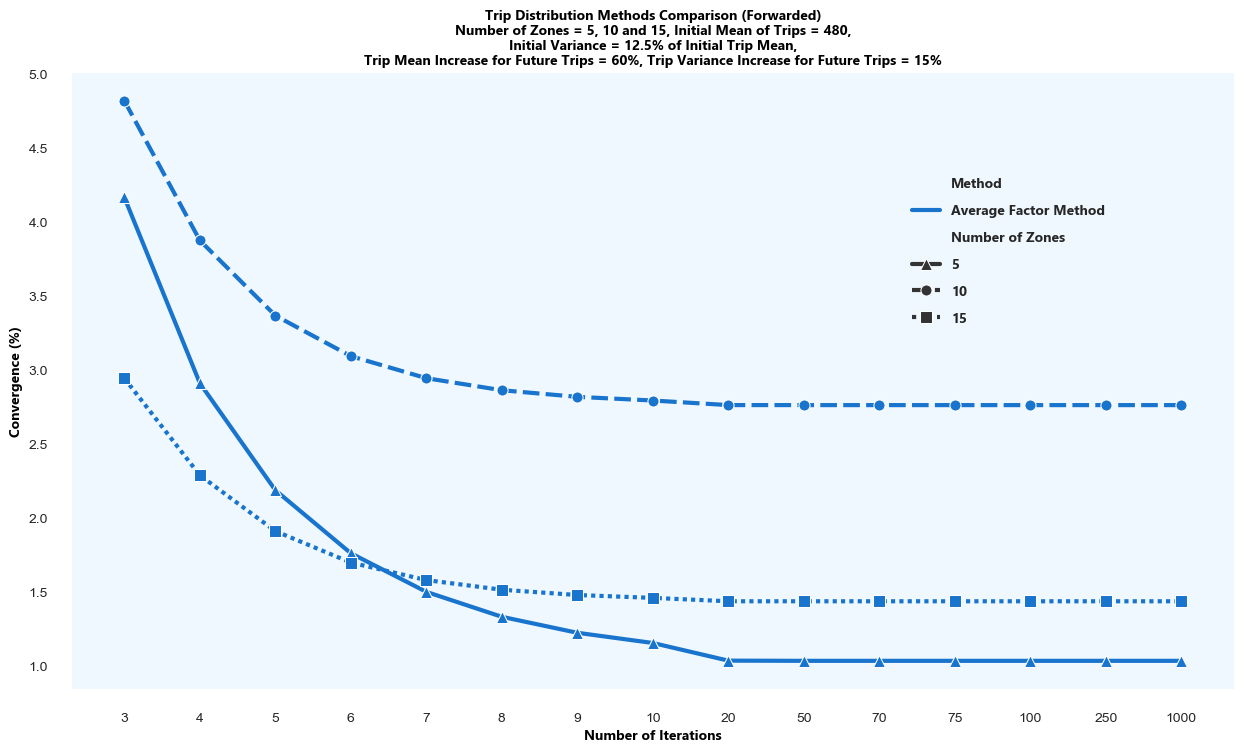

In [22]:
np.random.seed(252)
"""Comparison of Trip Distribution Methods (Random Normal Data)"""
"""First Comparison: Zones = 6, Initial Mean = 480, Initial Variance = 12.5% of Initial Mean, Mean Increase = 60%, Variance Increase = 15%"""
mock_1_present = np.random.normal(loc=480, scale=60, size=25).astype(int).reshape((5, 5))
np.fill_diagonal(mock_1_present, 0)
mock_1_future = np.random.normal(loc=768, scale=69, size=10).astype(int).reshape((5, 2))
total_present_trips_mock_1 = np.transpose(np.vstack((mock_1_present.sum(axis=1), mock_1_present.sum(axis=0))))
growth_rate_mock_1 = mock_1_future / total_present_trips_mock_1

"""Second Comparison: Zones = 10, Initial Mean = 480, Initial Variance = 12.5% of Initial Mean, Mean Increase = 60%, Variance Increase = 15%"""
mock_2_present = np.random.normal(loc=480, scale=60, size=100).astype(int).reshape((10, 10))
np.fill_diagonal(mock_2_present, 0)
mock_2_future = np.random.normal(loc=768, scale=69, size=20).astype(int).reshape((10, 2))
total_present_trips_mock_2 = np.transpose(np.vstack((mock_2_present.sum(axis=1), mock_2_present.sum(axis=0))))
growth_rate_mock_2 = mock_2_future / total_present_trips_mock_2

"""Third Comparison: Zones = 15, Initial Mean = 480, Initial Variance = 12.5% of Initial Mean, Mean Increase = 60%, Variance Increase = 15%"""
mock_3_present = np.random.normal(loc=480, scale=60, size=225).astype(int).reshape((15, 15))
np.fill_diagonal(mock_3_present, 0)
mock_3_future = np.random.normal(loc=768, scale=69, size=30).astype(int).reshape((15, 2))
total_present_trips_mock_3 = np.transpose(np.vstack((mock_3_present.sum(axis=1), mock_3_present.sum(axis=0))))
growth_rate_mock_3 = mock_3_future / total_present_trips_mock_3

comparison_df = pd.DataFrame({
    "Method" : np.hstack((np.array(["Average Factor Method"]*45))),
    "Number of Zones" : np.hstack((np.array(["5"]*15), np.array(["10"]*15), np.array(["15"]*15))),
    "Iteration" : np.array(["3", "4", "5", "6", "7", "8", "9", "10", "20", "50", "70", "75", "100", "250", "1000"]*3),
    "Convergence" : [afm(mock_1_present, mock_1_future, growth_rate_mock_1, 3),
                     afm(mock_1_present, mock_1_future, growth_rate_mock_1, 4),
                     afm(mock_1_present, mock_1_future, growth_rate_mock_1, 5),
                     afm(mock_1_present, mock_1_future, growth_rate_mock_1, 6),
                     afm(mock_1_present, mock_1_future, growth_rate_mock_1, 7),
                     afm(mock_1_present, mock_1_future, growth_rate_mock_1, 8),
                     afm(mock_1_present, mock_1_future, growth_rate_mock_1, 9),
                     afm(mock_1_present, mock_1_future, growth_rate_mock_1, 10),
                     afm(mock_1_present, mock_1_future, growth_rate_mock_1, 20),
                     afm(mock_1_present, mock_1_future, growth_rate_mock_1, 50),
                     afm(mock_1_present, mock_1_future, growth_rate_mock_1, 70),
                     afm(mock_1_present, mock_1_future, growth_rate_mock_1, 75),
                     afm(mock_1_present, mock_1_future, growth_rate_mock_1, 100),
                     afm(mock_1_present, mock_1_future, growth_rate_mock_1, 250),
                     afm(mock_1_present, mock_1_future, growth_rate_mock_1, 1000),
                     afm(mock_2_present, mock_2_future, growth_rate_mock_2, 3),
                     afm(mock_2_present, mock_2_future, growth_rate_mock_2, 4),
                     afm(mock_2_present, mock_2_future, growth_rate_mock_2, 5),
                     afm(mock_2_present, mock_2_future, growth_rate_mock_2, 6),
                     afm(mock_2_present, mock_2_future, growth_rate_mock_2, 7),
                     afm(mock_2_present, mock_2_future, growth_rate_mock_2, 8),
                     afm(mock_2_present, mock_2_future, growth_rate_mock_2, 9),
                     afm(mock_2_present, mock_2_future, growth_rate_mock_2, 10),
                     afm(mock_2_present, mock_2_future, growth_rate_mock_2, 20),
                     afm(mock_2_present, mock_2_future, growth_rate_mock_2, 50),
                     afm(mock_2_present, mock_2_future, growth_rate_mock_2, 70),
                     afm(mock_2_present, mock_2_future, growth_rate_mock_2, 75),
                     afm(mock_2_present, mock_2_future, growth_rate_mock_2, 100),
                     afm(mock_2_present, mock_2_future, growth_rate_mock_2, 250),
                     afm(mock_2_present, mock_2_future, growth_rate_mock_2, 1000),
                     afm(mock_3_present, mock_3_future, growth_rate_mock_3, 3),
                     afm(mock_3_present, mock_3_future, growth_rate_mock_3, 4),
                     afm(mock_3_present, mock_3_future, growth_rate_mock_3, 5),
                     afm(mock_3_present, mock_3_future, growth_rate_mock_3, 6),
                     afm(mock_3_present, mock_3_future, growth_rate_mock_3, 7),
                     afm(mock_3_present, mock_3_future, growth_rate_mock_3, 8),
                     afm(mock_3_present, mock_3_future, growth_rate_mock_3, 9),
                     afm(mock_3_present, mock_3_future, growth_rate_mock_3, 10),
                     afm(mock_3_present, mock_3_future, growth_rate_mock_3, 20),
                     afm(mock_3_present, mock_3_future, growth_rate_mock_3, 50),
                     afm(mock_3_present, mock_3_future, growth_rate_mock_3, 70),
                     afm(mock_3_present, mock_3_future, growth_rate_mock_3, 75),
                     afm(mock_3_present, mock_3_future, growth_rate_mock_3, 100),
                     afm(mock_3_present, mock_3_future, growth_rate_mock_3, 250),
                     afm(mock_3_present, mock_3_future, growth_rate_mock_3, 1000),
                     ]
}, columns=["Method", "Number of Zones", "Iteration", "Convergence"])
sns.set_style("dark", {"axes.facecolor" : "#F0F8FF"})
fig, comparison_df_plot = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
sns.lineplot(data=comparison_df, x="Iteration", y="Convergence", hue="Method", palette=["#1874CD"],
             linewidth=3, markers=["^", "o", "s"], markersize=8, style="Number of Zones")
sns.despine(fig=fig, ax=comparison_df_plot, top=True, right=True, offset=10)
comparison_df_plot.set_title("Trip Distribution Methods Comparison (Forwarded)\nNumber of Zones = 5, 10 and 15, Initial Mean of Trips = 480,"
                               "\nInitial Variance = 12.5% of Initial Trip Mean,"
                               "\nTrip Mean Increase for Future Trips = 60%, Trip Variance Increase for Future Trips = 15%",
                               fontdict={"font": "Nirmala UI", "color": "black", "fontsize": 10, "weight": "bold"})
comparison_df_plot.set_xlabel("Number of Iterations", fontdict={"font": "Nirmala UI", "color": "black", "fontsize": 10, "weight": "bold"})
comparison_df_plot.set_ylabel("Convergence (%)", fontdict={"font": "Nirmala UI", "color": "black", "fontsize": 10, "weight": "bold"})
comparison_1_df_plot_legend = comparison_df_plot.legend(labelspacing=1, edgecolor = "#1874CD", fontsize=10, frameon=False, bbox_to_anchor=(0.9, 0.85),
                                                        prop={"family":"Nirmala UI", "weight": "bold", "style": "normal", "size": 10})#,
                                                        #title="Trip Distribution Methods")
title_comparison_1_df_plot = comparison_1_df_plot_legend.get_title()
title_comparison_1_df_plot.set_family("Nirmala UI")
title_comparison_1_df_plot.set_weight("bold")
title_comparison_1_df_plot.set_size(10)

#### ii. Detroit Method

In [23]:
def dm(present_trips, future_trips, growth_rate, dm_iteration):
    
    dm_iteration = dm_iteration
    present_trips = present_trips
    future_trips = future_trips
    growth_rate = growth_rate
    dm_growth_rate = np.zeros((growth_rate.shape[-2] * (dm_iteration + 2), growth_rate.shape[-1]))
    dm_array = np.zeros(((dm_iteration + 2) * present_trips.shape[-2], present_trips.shape[-1]))
    dm_recharging_array = np.zeros((present_trips.shape[-2], present_trips.shape[-1]))
    dm_recharging_growth_rate = np.zeros_like(dm_recharging_array, dtype=float)
    # dm_growth_rate = np.zeros_like(dm_array, dtype=float)

    for i in range(present_trips.shape[-2]):
        for j in range(present_trips.shape[-1]):
            for k in range(growth_rate.shape[-1]):
                dm_growth_rate[i, k] = growth_rate[i, k]
            dm_array[i, j] = present_trips[i, j]
    
    for t in range(dm_iteration):
        current_recharging_array_sum = dm_array[
            (present_trips.shape[-2] * t): (present_trips.shape[-2] * (t + 1)),
            0 : (present_trips.shape[-1] + 1)
            ].sum(axis=1).sum(axis=0)
        current_total_growth_rate = (future_trips.sum(axis=0)[0])/current_recharging_array_sum
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                dm_recharging_growth_rate[i, j] = (dm_growth_rate[(present_trips.shape[-2] * t) + i, 0] \
                                                   * dm_growth_rate[(present_trips.shape[-2] * t) + j, 1]) \
                                                    * (1/current_total_growth_rate)    # not advanced
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                dm_recharging_array[i, j] = dm_array[(present_trips.shape[-2] * t) + i, j]  # not advanced
        # for i in range(present_trips.shape[-2]):
        #     for j in range(present_trips.shape[-1]):
        #         dm_growth_rate[(present_trips.shape[-2] * t) + i, j] = dm_recharging_growth_rate[i, j]    # not advanced
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                dm_array[(present_trips.shape[-2] * (t + 1)) + i, j] = dm_recharging_array[i, j] * dm_recharging_growth_rate[i, j]    # advanced
        new_recharging_array_sum = np.transpose(np.vstack(
            (
                dm_array[
                    (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                    0 : (present_trips.shape[-1])
                    ].sum(axis=1),
                dm_array[
                    (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                    0 : (present_trips.shape[-1])
                    ].sum(axis=0)
            )
        ))
        new_recharging_growth_rate = future_trips/new_recharging_array_sum
        for i in range(present_trips.shape[-2]):
            for j in range(growth_rate.shape[-1]):
                dm_growth_rate[(present_trips.shape[-2] * (t + 1)) + i, j] = new_recharging_growth_rate[i, j]    # advanced
    
    mock_convergence = np.ones((present_trips.shape[-2], dm_growth_rate.shape[-1]), dtype=float)
    
    dm_convergence = dm_growth_rate[((present_trips.shape[-2] * (dm_iteration + 1)) - present_trips.shape[-2]):
                                         present_trips.shape[-2] * (dm_iteration + 1), 0: dm_growth_rate.shape[-1]]
    
    return np.amax(np.absolute(dm_convergence - mock_convergence)) * 100

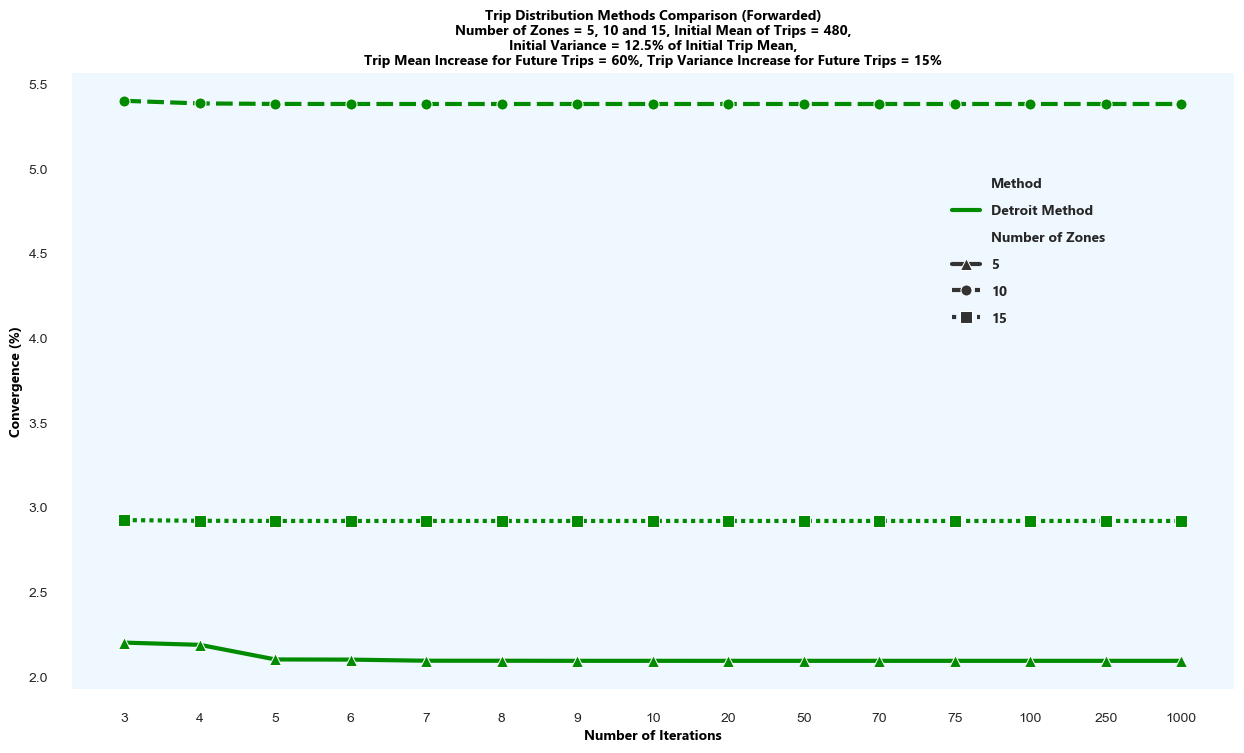

In [24]:
np.random.seed(252)
"""Comparison of Trip Distribution Methods (Random Normal Data)"""
"""First Comparison: Zones = 6, Initial Mean = 480, Initial Variance = 12.5% of Initial Mean, Mean Increase = 60%, Variance Increase = 15%"""
mock_1_present = np.random.normal(loc=480, scale=60, size=25).astype(int).reshape((5, 5))
np.fill_diagonal(mock_1_present, 0)
mock_1_future = np.random.normal(loc=768, scale=69, size=10).astype(int).reshape((5, 2))
total_present_trips_mock_1 = np.transpose(np.vstack((mock_1_present.sum(axis=1), mock_1_present.sum(axis=0))))
growth_rate_mock_1 = mock_1_future / total_present_trips_mock_1

"""Second Comparison: Zones = 10, Initial Mean = 480, Initial Variance = 12.5% of Initial Mean, Mean Increase = 60%, Variance Increase = 15%"""
mock_2_present = np.random.normal(loc=480, scale=60, size=100).astype(int).reshape((10, 10))
np.fill_diagonal(mock_2_present, 0)
mock_2_future = np.random.normal(loc=768, scale=69, size=20).astype(int).reshape((10, 2))
total_present_trips_mock_2 = np.transpose(np.vstack((mock_2_present.sum(axis=1), mock_2_present.sum(axis=0))))
growth_rate_mock_2 = mock_2_future / total_present_trips_mock_2

"""Third Comparison: Zones = 15, Initial Mean = 480, Initial Variance = 12.5% of Initial Mean, Mean Increase = 60%, Variance Increase = 15%"""
mock_3_present = np.random.normal(loc=480, scale=60, size=225).astype(int).reshape((15, 15))
np.fill_diagonal(mock_3_present, 0)
mock_3_future = np.random.normal(loc=768, scale=69, size=30).astype(int).reshape((15, 2))
total_present_trips_mock_3 = np.transpose(np.vstack((mock_3_present.sum(axis=1), mock_3_present.sum(axis=0))))
growth_rate_mock_3 = mock_3_future / total_present_trips_mock_3

comparison_df = pd.DataFrame({
    "Method" : np.hstack((np.array(["Detroit Method"]*45))),
    "Number of Zones" : np.hstack((np.array(["5"]*15), np.array(["10"]*15), np.array(["15"]*15))),
    "Iteration" : np.array(["3", "4", "5", "6", "7", "8", "9", "10", "20", "50", "70", "75", "100", "250", "1000"]*3),
    "Convergence" : [dm(mock_1_present, mock_1_future, growth_rate_mock_1, 3),
                     dm(mock_1_present, mock_1_future, growth_rate_mock_1, 4),
                     dm(mock_1_present, mock_1_future, growth_rate_mock_1, 5),
                     dm(mock_1_present, mock_1_future, growth_rate_mock_1, 6),
                     dm(mock_1_present, mock_1_future, growth_rate_mock_1, 7),
                     dm(mock_1_present, mock_1_future, growth_rate_mock_1, 8),
                     dm(mock_1_present, mock_1_future, growth_rate_mock_1, 9),
                     dm(mock_1_present, mock_1_future, growth_rate_mock_1, 10),
                     dm(mock_1_present, mock_1_future, growth_rate_mock_1, 20),
                     dm(mock_1_present, mock_1_future, growth_rate_mock_1, 50),
                     dm(mock_1_present, mock_1_future, growth_rate_mock_1, 70),
                     dm(mock_1_present, mock_1_future, growth_rate_mock_1, 75),
                     dm(mock_1_present, mock_1_future, growth_rate_mock_1, 100),
                     dm(mock_1_present, mock_1_future, growth_rate_mock_1, 250),
                     dm(mock_1_present, mock_1_future, growth_rate_mock_1, 1000),
                     dm(mock_2_present, mock_2_future, growth_rate_mock_2, 3),
                     dm(mock_2_present, mock_2_future, growth_rate_mock_2, 4),
                     dm(mock_2_present, mock_2_future, growth_rate_mock_2, 5),
                     dm(mock_2_present, mock_2_future, growth_rate_mock_2, 6),
                     dm(mock_2_present, mock_2_future, growth_rate_mock_2, 7),
                     dm(mock_2_present, mock_2_future, growth_rate_mock_2, 8),
                     dm(mock_2_present, mock_2_future, growth_rate_mock_2, 9),
                     dm(mock_2_present, mock_2_future, growth_rate_mock_2, 10),
                     dm(mock_2_present, mock_2_future, growth_rate_mock_2, 20),
                     dm(mock_2_present, mock_2_future, growth_rate_mock_2, 50),
                     dm(mock_2_present, mock_2_future, growth_rate_mock_2, 70),
                     dm(mock_2_present, mock_2_future, growth_rate_mock_2, 75),
                     dm(mock_2_present, mock_2_future, growth_rate_mock_2, 100),
                     dm(mock_2_present, mock_2_future, growth_rate_mock_2, 250),
                     dm(mock_2_present, mock_2_future, growth_rate_mock_2, 1000),
                     dm(mock_3_present, mock_3_future, growth_rate_mock_3, 3),
                     dm(mock_3_present, mock_3_future, growth_rate_mock_3, 4),
                     dm(mock_3_present, mock_3_future, growth_rate_mock_3, 5),
                     dm(mock_3_present, mock_3_future, growth_rate_mock_3, 6),
                     dm(mock_3_present, mock_3_future, growth_rate_mock_3, 7),
                     dm(mock_3_present, mock_3_future, growth_rate_mock_3, 8),
                     dm(mock_3_present, mock_3_future, growth_rate_mock_3, 9),
                     dm(mock_3_present, mock_3_future, growth_rate_mock_3, 10),
                     dm(mock_3_present, mock_3_future, growth_rate_mock_3, 20),
                     dm(mock_3_present, mock_3_future, growth_rate_mock_3, 50),
                     dm(mock_3_present, mock_3_future, growth_rate_mock_3, 70),
                     dm(mock_3_present, mock_3_future, growth_rate_mock_3, 75),
                     dm(mock_3_present, mock_3_future, growth_rate_mock_3, 100),
                     dm(mock_3_present, mock_3_future, growth_rate_mock_3, 250),
                     dm(mock_3_present, mock_3_future, growth_rate_mock_3, 1000),
                     ]
}, columns=["Method", "Number of Zones", "Iteration", "Convergence"])
sns.set_style("dark", {"axes.facecolor" : "#F0F8FF"})
fig, comparison_df_plot = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
sns.lineplot(data=comparison_df, x="Iteration", y="Convergence", hue="Method", palette=["#008B00"],
             linewidth=3, markers=["^", "o", "s"], markersize=8, style="Number of Zones")
sns.despine(fig=fig, ax=comparison_df_plot, top=True, right=True, offset=10)
comparison_df_plot.set_title("Trip Distribution Methods Comparison (Forwarded)\nNumber of Zones = 5, 10 and 15, Initial Mean of Trips = 480,"
                               "\nInitial Variance = 12.5% of Initial Trip Mean,"
                               "\nTrip Mean Increase for Future Trips = 60%, Trip Variance Increase for Future Trips = 15%",
                               fontdict={"font": "Nirmala UI", "color": "black", "fontsize": 10, "weight": "bold"})
comparison_df_plot.set_xlabel("Number of Iterations", fontdict={"font": "Nirmala UI", "color": "black", "fontsize": 10, "weight": "bold"})
comparison_df_plot.set_ylabel("Convergence (%)", fontdict={"font": "Nirmala UI", "color": "black", "fontsize": 10, "weight": "bold"})
comparison_1_df_plot_legend = comparison_df_plot.legend(labelspacing=1, edgecolor = "#1874CD", fontsize=10, frameon=False, bbox_to_anchor=(0.9, 0.85),
                                                        prop={"family":"Nirmala UI", "weight": "bold", "style": "normal", "size": 10})#,
                                                        #title="Trip Distribution Methods")
title_comparison_1_df_plot = comparison_1_df_plot_legend.get_title()
title_comparison_1_df_plot.set_family("Nirmala UI")
title_comparison_1_df_plot.set_weight("bold")
title_comparison_1_df_plot.set_size(10)

#### iii. Fratar Method

In [25]:
def fm(present_trips, future_trips, growth_rate, fm_iteration):

    fm_iteration = fm_iteration
    present_trips = present_trips
    future_trips = future_trips
    growth_rate = growth_rate
    
    fm_growth_rate = np.zeros((growth_rate.shape[-2] * (fm_iteration + 2), growth_rate.shape[-1]))
    fm_array = np.zeros(((fm_iteration + 2) * present_trips.shape[-2], present_trips.shape[-1]))
    # fm_growth_rate = np.zeros_like(fm_array, dtype=float)
    fm_recharging_array = np.zeros((present_trips.shape[-2], present_trips.shape[-1]))
    fm_recharging_growth_rate = np.zeros_like(fm_recharging_array, dtype=float)
    fm_trip_growth_rate_divisor = np.zeros_like(present_trips, dtype=float)
    
    for i in range(present_trips.shape[-2]):
        for j in range(present_trips.shape[-1]):
            for k in range(growth_rate.shape[-1]):
                fm_growth_rate[i, k] = growth_rate[i, k]
            fm_array[i, j] = present_trips[i, j]
    
    for t in range((fm_iteration) + 1):
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fm_recharging_array[i, j] = fm_array[(present_trips.shape[-2] * t) + i, j]      # not advanced
        fm_current_growth_rate = fm_growth_rate[
            (present_trips.shape[-2] * t): (present_trips.shape[-2] * (t + 1)),
            0: growth_rate.shape[-1]]       # not advanced
        trips_attraction_growth_rate_sum = np.matmul(fm_recharging_array, fm_current_growth_rate)
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fm_trip_growth_rate_divisor[i, j] = (trips_attraction_growth_rate_sum[:, 1])[i]
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fm_recharging_growth_rate[i, j] = (fm_growth_rate[(present_trips.shape[-2] * t) + i, 0] *      # not advanced
                                                   fm_growth_rate[(present_trips.shape[-2] * t) + j, 1]) * \
                                                  (fm_recharging_array.sum(axis=1)[i]) / fm_trip_growth_rate_divisor[i, 1]

        # for i in range(present_trips.shape[-2]):
        #     for j in range(present_trips.shape[-1]):
        #         fm_growth_rate[(present_trips.shape[-2] * t) + i, j] = fm_recharging_growth_rate[i, j]    # not advanced
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fm_array[(present_trips.shape[-2] * (t + 1)) + i, j] = fm_recharging_array[i, j] * fm_recharging_growth_rate[i, j]    # advanced
        new_recharging_array_sum = np.transpose(np.vstack(
            (fm_array[
                (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                0 : (present_trips.shape[-1])
                ].sum(axis=1),
            fm_array[
                (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                0 : (present_trips.shape[-1])
                ].sum(axis=0)
            )
        ))
        new_recharging_growth_rate = future_trips/new_recharging_array_sum
        for i in range(present_trips.shape[-2]):
            for j in range(growth_rate.shape[-1]):
                fm_growth_rate[(present_trips.shape[-2] * (t + 1)) + i, j] = new_recharging_growth_rate[i, j]    # advanced
    
    mock_convergence = np.ones((present_trips.shape[-2], fm_growth_rate.shape[-1]), dtype=float)
    
    fm_convergence = fm_growth_rate[
        ((present_trips.shape[-2] * (fm_iteration + 1)) - present_trips.shape[-2]): present_trips.shape[-2] * (fm_iteration + 1),
        0: fm_growth_rate.shape[-1]
    ]
    
    return np.amax(np.absolute(fm_convergence - mock_convergence)) * 100

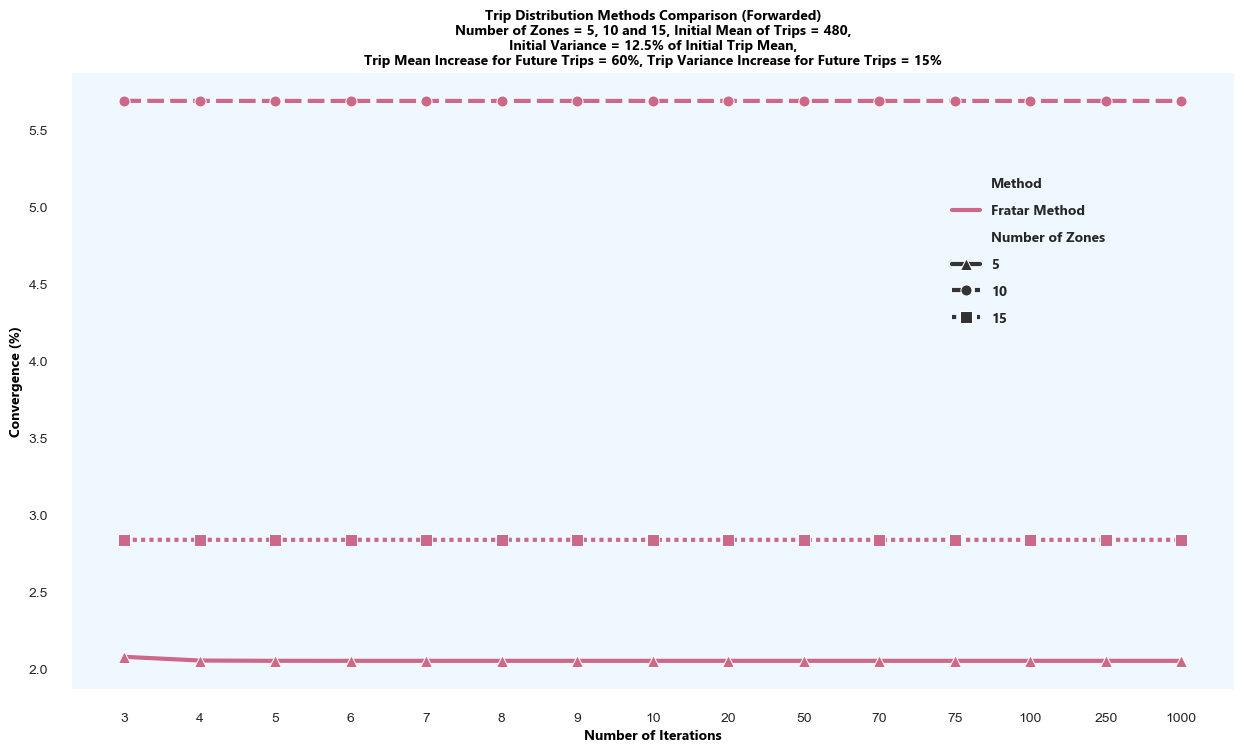

In [26]:
np.random.seed(252)
"""Comparison of Trip Distribution Methods (Random Normal Data)"""
"""First Comparison: Zones = 6, Initial Mean = 480, Initial Variance = 12.5% of Initial Mean, Mean Increase = 60%, Variance Increase = 15%"""
mock_1_present = np.random.normal(loc=480, scale=60, size=25).astype(int).reshape((5, 5))
np.fill_diagonal(mock_1_present, 0)
mock_1_future = np.random.normal(loc=768, scale=69, size=10).astype(int).reshape((5, 2))
total_present_trips_mock_1 = np.transpose(np.vstack((mock_1_present.sum(axis=1), mock_1_present.sum(axis=0))))
growth_rate_mock_1 = mock_1_future / total_present_trips_mock_1

"""Second Comparison: Zones = 10, Initial Mean = 480, Initial Variance = 12.5% of Initial Mean, Mean Increase = 60%, Variance Increase = 15%"""
mock_2_present = np.random.normal(loc=480, scale=60, size=100).astype(int).reshape((10, 10))
np.fill_diagonal(mock_2_present, 0)
mock_2_future = np.random.normal(loc=768, scale=69, size=20).astype(int).reshape((10, 2))
total_present_trips_mock_2 = np.transpose(np.vstack((mock_2_present.sum(axis=1), mock_2_present.sum(axis=0))))
growth_rate_mock_2 = mock_2_future / total_present_trips_mock_2

"""Third Comparison: Zones = 15, Initial Mean = 480, Initial Variance = 12.5% of Initial Mean, Mean Increase = 60%, Variance Increase = 15%"""
mock_3_present = np.random.normal(loc=480, scale=60, size=225).astype(int).reshape((15, 15))
np.fill_diagonal(mock_3_present, 0)
mock_3_future = np.random.normal(loc=768, scale=69, size=30).astype(int).reshape((15, 2))
total_present_trips_mock_3 = np.transpose(np.vstack((mock_3_present.sum(axis=1), mock_3_present.sum(axis=0))))
growth_rate_mock_3 = mock_3_future / total_present_trips_mock_3

comparison_df = pd.DataFrame({
    "Method" : np.hstack((np.array(["Fratar Method"]*45))),
    "Number of Zones" : np.hstack((np.array(["5"]*15), np.array(["10"]*15), np.array(["15"]*15))),
    "Iteration" : np.array(["3", "4", "5", "6", "7", "8", "9", "10", "20", "50", "70", "75", "100", "250", "1000"]*3),
    "Convergence" : [fm(mock_1_present, mock_1_future, growth_rate_mock_1, 3),
                     fm(mock_1_present, mock_1_future, growth_rate_mock_1, 4),
                     fm(mock_1_present, mock_1_future, growth_rate_mock_1, 5),
                     fm(mock_1_present, mock_1_future, growth_rate_mock_1, 6),
                     fm(mock_1_present, mock_1_future, growth_rate_mock_1, 7),
                     fm(mock_1_present, mock_1_future, growth_rate_mock_1, 8),
                     fm(mock_1_present, mock_1_future, growth_rate_mock_1, 9),
                     fm(mock_1_present, mock_1_future, growth_rate_mock_1, 10),
                     fm(mock_1_present, mock_1_future, growth_rate_mock_1, 20),
                     fm(mock_1_present, mock_1_future, growth_rate_mock_1, 50),
                     fm(mock_1_present, mock_1_future, growth_rate_mock_1, 70),
                     fm(mock_1_present, mock_1_future, growth_rate_mock_1, 75),
                     fm(mock_1_present, mock_1_future, growth_rate_mock_1, 100),
                     fm(mock_1_present, mock_1_future, growth_rate_mock_1, 250),
                     fm(mock_1_present, mock_1_future, growth_rate_mock_1, 1000),
                     fm(mock_2_present, mock_2_future, growth_rate_mock_2, 3),
                     fm(mock_2_present, mock_2_future, growth_rate_mock_2, 4),
                     fm(mock_2_present, mock_2_future, growth_rate_mock_2, 5),
                     fm(mock_2_present, mock_2_future, growth_rate_mock_2, 6),
                     fm(mock_2_present, mock_2_future, growth_rate_mock_2, 7),
                     fm(mock_2_present, mock_2_future, growth_rate_mock_2, 8),
                     fm(mock_2_present, mock_2_future, growth_rate_mock_2, 9),
                     fm(mock_2_present, mock_2_future, growth_rate_mock_2, 10),
                     fm(mock_2_present, mock_2_future, growth_rate_mock_2, 20),
                     fm(mock_2_present, mock_2_future, growth_rate_mock_2, 50),
                     fm(mock_2_present, mock_2_future, growth_rate_mock_2, 70),
                     fm(mock_2_present, mock_2_future, growth_rate_mock_2, 75),
                     fm(mock_2_present, mock_2_future, growth_rate_mock_2, 100),
                     fm(mock_2_present, mock_2_future, growth_rate_mock_2, 250),
                     fm(mock_2_present, mock_2_future, growth_rate_mock_2, 1000),
                     fm(mock_3_present, mock_3_future, growth_rate_mock_3, 3),
                     fm(mock_3_present, mock_3_future, growth_rate_mock_3, 4),
                     fm(mock_3_present, mock_3_future, growth_rate_mock_3, 5),
                     fm(mock_3_present, mock_3_future, growth_rate_mock_3, 6),
                     fm(mock_3_present, mock_3_future, growth_rate_mock_3, 7),
                     fm(mock_3_present, mock_3_future, growth_rate_mock_3, 8),
                     fm(mock_3_present, mock_3_future, growth_rate_mock_3, 9),
                     fm(mock_3_present, mock_3_future, growth_rate_mock_3, 10),
                     fm(mock_3_present, mock_3_future, growth_rate_mock_3, 20),
                     fm(mock_3_present, mock_3_future, growth_rate_mock_3, 50),
                     fm(mock_3_present, mock_3_future, growth_rate_mock_3, 70),
                     fm(mock_3_present, mock_3_future, growth_rate_mock_3, 75),
                     fm(mock_3_present, mock_3_future, growth_rate_mock_3, 100),
                     fm(mock_3_present, mock_3_future, growth_rate_mock_3, 250),
                     fm(mock_3_present, mock_3_future, growth_rate_mock_3, 1000),
                     ]
}, columns=["Method", "Number of Zones", "Iteration", "Convergence"])
sns.set_style("dark", {"axes.facecolor" : "#F0F8FF"})
fig, comparison_df_plot = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
sns.lineplot(data=comparison_df, x="Iteration", y="Convergence", hue="Method", palette=["#CD6889"],
             linewidth=3, markers=["^", "o", "s"], markersize=8, style="Number of Zones")
sns.despine(fig=fig, ax=comparison_df_plot, top=True, right=True, offset=10)
comparison_df_plot.set_title("Trip Distribution Methods Comparison (Forwarded)\nNumber of Zones = 5, 10 and 15, Initial Mean of Trips = 480,"
                               "\nInitial Variance = 12.5% of Initial Trip Mean,"
                               "\nTrip Mean Increase for Future Trips = 60%, Trip Variance Increase for Future Trips = 15%",
                               fontdict={"font": "Nirmala UI", "color": "black", "fontsize": 10, "weight": "bold"})
comparison_df_plot.set_xlabel("Number of Iterations", fontdict={"font": "Nirmala UI", "color": "black", "fontsize": 10, "weight": "bold"})
comparison_df_plot.set_ylabel("Convergence (%)", fontdict={"font": "Nirmala UI", "color": "black", "fontsize": 10, "weight": "bold"})
comparison_1_df_plot_legend = comparison_df_plot.legend(labelspacing=1, edgecolor = "#1874CD", fontsize=10, frameon=False, bbox_to_anchor=(0.9, 0.85),
                                                        prop={"family":"Nirmala UI", "weight": "bold", "style": "normal", "size": 10})#,
                                                        #title="Trip Distribution Methods")
title_comparison_1_df_plot = comparison_1_df_plot_legend.get_title()
title_comparison_1_df_plot.set_family("Nirmala UI")
title_comparison_1_df_plot.set_weight("bold")
title_comparison_1_df_plot.set_size(10)

#### iv. Furness Method

In [27]:
def fur(present_trips, future_trips, growth_rate, fur_iteration):

    fur_iteration = fur_iteration
    present_trips = present_trips
    future_trips = future_trips
    growth_rate = growth_rate
    
    fur_growth_rate = np.zeros((growth_rate.shape[-2] * (fur_iteration + 2), growth_rate.shape[-1]))
    fur_array = np.zeros(((fur_iteration + 2) * present_trips.shape[-2], present_trips.shape[-1]))
    # fm_growth_rate = np.zeros_like(fm_array, dtype=float)
    fur_recharging_array = np.zeros((present_trips.shape[-2], present_trips.shape[-1]))
    fur_recharging_growth_rate = np.zeros_like(fur_recharging_array, dtype=float)
    fur_trip_growth_rate_divisor = np.zeros_like(present_trips, dtype=float)
    
    for i in range(present_trips.shape[-2]):
        for j in range(present_trips.shape[-1]):
            for k in range(growth_rate.shape[-1]):
                fur_growth_rate[i, k] = growth_rate[i, k]
            fur_array[i, j] = present_trips[i, j]
    
    for t in range((fur_iteration) + 1):
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fur_recharging_array[i, j] = fur_array[(present_trips.shape[-2] * t) + i, j]      # not advanced
        fur_current_growth_rate = fur_growth_rate[
            (present_trips.shape[-2] * t): (present_trips.shape[-2] * (t + 1)),
            0: growth_rate.shape[-1]]       # not advanced
        if divmod(t, 2)[-1] == 0:
            fur_recharging_growth_rate = fur_current_growth_rate[:, 0]
            for i in range(present_trips.shape[-2]):
                for j in range(present_trips.shape[-1]):
                    fur_array[(present_trips.shape[-2] * (t + 1)) + i, j] = fur_recharging_array[i, j] * fur_recharging_growth_rate[i]      # advanced
        else:
            fur_recharging_growth_rate = fur_current_growth_rate[:, 1]
            for i in range(present_trips.shape[-2]):
                for j in range(present_trips.shape[-1]):
                    fur_array[(present_trips.shape[-2] * (t + 1)) + i, j] = fur_recharging_array[i, j] * fur_recharging_growth_rate[j]      # advanced
        # trips_attraction_growth_rate_sum = np.matmul(fur_recharging_array, fur_current_growth_rate)
        # for i in range(present_trips.shape[-2]):
        #     for j in range(present_trips.shape[-1]):
        #         fur_trip_growth_rate_divisor[i, j] = (trips_attraction_growth_rate_sum[:, 1])[i]
        # for i in range(present_trips.shape[-2]):
        #     for j in range(present_trips.shape[-1]):
        #         fur_recharging_growth_rate[i, j] = (fur_growth_rate[(present_trips.shape[-2] * t) + i, 0] *      # not advanced
        #                                            fur_growth_rate[(present_trips.shape[-2] * t) + j, 1]) * \
        #                                           (fur_recharging_array.sum(axis=1)[i]) / fur_trip_growth_rate_divisor[i, 1]

        # for i in range(present_trips.shape[-2]):
        #     for j in range(present_trips.shape[-1]):
        #         fm_growth_rate[(present_trips.shape[-2] * t) + i, j] = fm_recharging_growth_rate[i, j]    # not advanced
        # for i in range(present_trips.shape[-2]):
        #     for j in range(present_trips.shape[-1]):
        #         fur_array[(present_trips.shape[-2] * (t + 1)) + i, j] = fur_recharging_array[i, j] * fur_recharging_growth_rate[i, j]    # advanced
        # for i in range(present_trips.shape[-2]):
        #     for j in range(present_trips.shape[-1]):
        #         fur_array[(present_trips.shape[-2] * (t + 1)) + i, j] = fur_recharging_array[i, j] * fur_recharging_growth_rate[i]    # advanced
        new_recharging_array_sum = np.transpose(np.vstack(
            (fur_array[
                (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                0 : (present_trips.shape[-1])
                ].sum(axis=1),
            fur_array[
                (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                0 : (present_trips.shape[-1])
                ].sum(axis=0)
            )
        ))
        new_recharging_growth_rate = future_trips/new_recharging_array_sum
        for i in range(present_trips.shape[-2]):
            for j in range(growth_rate.shape[-1]):
                fur_growth_rate[(present_trips.shape[-2] * (t + 1)) + i, j] = new_recharging_growth_rate[i, j]    # advanced
    
    mock_convergence = np.ones((present_trips.shape[-2], fur_growth_rate.shape[-1]), dtype=float)
    
    fur_convergence = fur_growth_rate[
        ((present_trips.shape[-2] * (fur_iteration + 1)) - present_trips.shape[-2]): present_trips.shape[-2] * (fur_iteration + 1),
        0: fur_growth_rate.shape[-1]
    ]
    
    return np.amax(np.absolute(fur_convergence - mock_convergence)) * 100

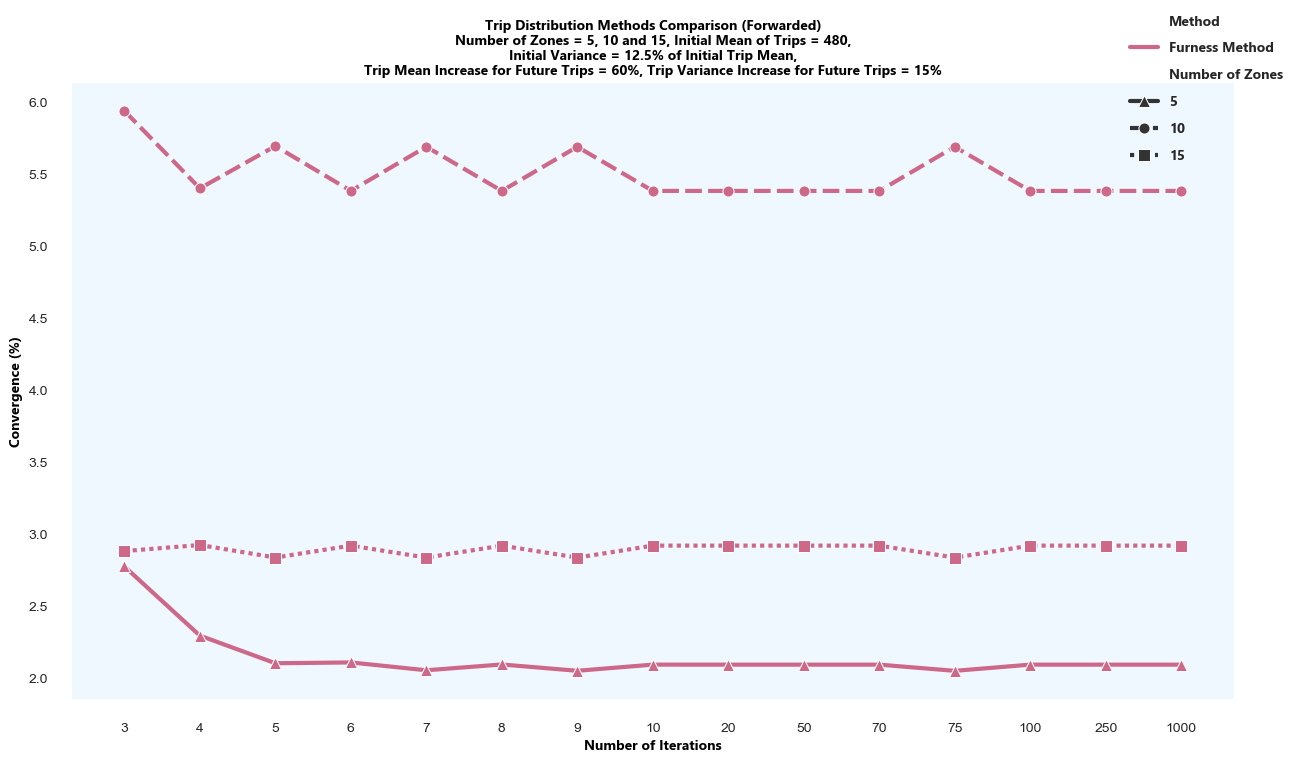

In [28]:
np.random.seed(252)
"""Comparison of Trip Distribution Methods (Random Normal Data)"""
"""First Comparison: Zones = 6, Initial Mean = 480, Initial Variance = 12.5% of Initial Mean, Mean Increase = 60%, Variance Increase = 15%"""
mock_1_present = np.random.normal(loc=480, scale=60, size=25).astype(int).reshape((5, 5))
np.fill_diagonal(mock_1_present, 0)
mock_1_future = np.random.normal(loc=768, scale=69, size=10).astype(int).reshape((5, 2))
total_present_trips_mock_1 = np.transpose(np.vstack((mock_1_present.sum(axis=1), mock_1_present.sum(axis=0))))
growth_rate_mock_1 = mock_1_future / total_present_trips_mock_1

"""Second Comparison: Zones = 10, Initial Mean = 480, Initial Variance = 12.5% of Initial Mean, Mean Increase = 60%, Variance Increase = 15%"""
mock_2_present = np.random.normal(loc=480, scale=60, size=100).astype(int).reshape((10, 10))
np.fill_diagonal(mock_2_present, 0)
mock_2_future = np.random.normal(loc=768, scale=69, size=20).astype(int).reshape((10, 2))
total_present_trips_mock_2 = np.transpose(np.vstack((mock_2_present.sum(axis=1), mock_2_present.sum(axis=0))))
growth_rate_mock_2 = mock_2_future / total_present_trips_mock_2

"""Third Comparison: Zones = 15, Initial Mean = 480, Initial Variance = 12.5% of Initial Mean, Mean Increase = 60%, Variance Increase = 15%"""
mock_3_present = np.random.normal(loc=480, scale=60, size=225).astype(int).reshape((15, 15))
np.fill_diagonal(mock_3_present, 0)
mock_3_future = np.random.normal(loc=768, scale=69, size=30).astype(int).reshape((15, 2))
total_present_trips_mock_3 = np.transpose(np.vstack((mock_3_present.sum(axis=1), mock_3_present.sum(axis=0))))
growth_rate_mock_3 = mock_3_future / total_present_trips_mock_3

comparison_df = pd.DataFrame({
    "Method" : np.hstack((np.array(["Furness Method"]*45))),
    "Number of Zones" : np.hstack((np.array(["5"]*15), np.array(["10"]*15), np.array(["15"]*15))),
    "Iteration" : np.array(["3", "4", "5", "6", "7", "8", "9", "10", "20", "50", "70", "75", "100", "250", "1000"]*3),
    "Convergence" : [fur(mock_1_present, mock_1_future, growth_rate_mock_1, 3),
                     fur(mock_1_present, mock_1_future, growth_rate_mock_1, 4),
                     fur(mock_1_present, mock_1_future, growth_rate_mock_1, 5),
                     fur(mock_1_present, mock_1_future, growth_rate_mock_1, 6),
                     fur(mock_1_present, mock_1_future, growth_rate_mock_1, 7),
                     fur(mock_1_present, mock_1_future, growth_rate_mock_1, 8),
                     fur(mock_1_present, mock_1_future, growth_rate_mock_1, 9),
                     fur(mock_1_present, mock_1_future, growth_rate_mock_1, 10),
                     fur(mock_1_present, mock_1_future, growth_rate_mock_1, 20),
                     fur(mock_1_present, mock_1_future, growth_rate_mock_1, 50),
                     fur(mock_1_present, mock_1_future, growth_rate_mock_1, 70),
                     fur(mock_1_present, mock_1_future, growth_rate_mock_1, 75),
                     fur(mock_1_present, mock_1_future, growth_rate_mock_1, 100),
                     fur(mock_1_present, mock_1_future, growth_rate_mock_1, 250),
                     fur(mock_1_present, mock_1_future, growth_rate_mock_1, 1000),
                     fur(mock_2_present, mock_2_future, growth_rate_mock_2, 3),
                     fur(mock_2_present, mock_2_future, growth_rate_mock_2, 4),
                     fur(mock_2_present, mock_2_future, growth_rate_mock_2, 5),
                     fur(mock_2_present, mock_2_future, growth_rate_mock_2, 6),
                     fur(mock_2_present, mock_2_future, growth_rate_mock_2, 7),
                     fur(mock_2_present, mock_2_future, growth_rate_mock_2, 8),
                     fur(mock_2_present, mock_2_future, growth_rate_mock_2, 9),
                     fur(mock_2_present, mock_2_future, growth_rate_mock_2, 10),
                     fur(mock_2_present, mock_2_future, growth_rate_mock_2, 20),
                     fur(mock_2_present, mock_2_future, growth_rate_mock_2, 50),
                     fur(mock_2_present, mock_2_future, growth_rate_mock_2, 70),
                     fur(mock_2_present, mock_2_future, growth_rate_mock_2, 75),
                     fur(mock_2_present, mock_2_future, growth_rate_mock_2, 100),
                     fur(mock_2_present, mock_2_future, growth_rate_mock_2, 250),
                     fur(mock_2_present, mock_2_future, growth_rate_mock_2, 1000),
                     fur(mock_3_present, mock_3_future, growth_rate_mock_3, 3),
                     fur(mock_3_present, mock_3_future, growth_rate_mock_3, 4),
                     fur(mock_3_present, mock_3_future, growth_rate_mock_3, 5),
                     fur(mock_3_present, mock_3_future, growth_rate_mock_3, 6),
                     fur(mock_3_present, mock_3_future, growth_rate_mock_3, 7),
                     fur(mock_3_present, mock_3_future, growth_rate_mock_3, 8),
                     fur(mock_3_present, mock_3_future, growth_rate_mock_3, 9),
                     fur(mock_3_present, mock_3_future, growth_rate_mock_3, 10),
                     fur(mock_3_present, mock_3_future, growth_rate_mock_3, 20),
                     fur(mock_3_present, mock_3_future, growth_rate_mock_3, 50),
                     fur(mock_3_present, mock_3_future, growth_rate_mock_3, 70),
                     fur(mock_3_present, mock_3_future, growth_rate_mock_3, 75),
                     fur(mock_3_present, mock_3_future, growth_rate_mock_3, 100),
                     fur(mock_3_present, mock_3_future, growth_rate_mock_3, 250),
                     fur(mock_3_present, mock_3_future, growth_rate_mock_3, 1000),
                     ]
}, columns=["Method", "Number of Zones", "Iteration", "Convergence"])
sns.set_style("dark", {"axes.facecolor" : "#F0F8FF"})
fig, comparison_df_plot = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
sns.lineplot(data=comparison_df, x="Iteration", y="Convergence", hue="Method", palette=["#CD6889"],
             linewidth=3, markers=["^", "o", "s"], markersize=8, style="Number of Zones")
sns.despine(fig=fig, ax=comparison_df_plot, top=True, right=True, offset=10)
comparison_df_plot.set_title("Trip Distribution Methods Comparison (Forwarded)\nNumber of Zones = 5, 10 and 15, Initial Mean of Trips = 480,"
                               "\nInitial Variance = 12.5% of Initial Trip Mean,"
                               "\nTrip Mean Increase for Future Trips = 60%, Trip Variance Increase for Future Trips = 15%",
                               fontdict={"font": "Nirmala UI", "color": "black", "fontsize": 10, "weight": "bold"})
comparison_df_plot.set_xlabel("Number of Iterations", fontdict={"font": "Nirmala UI", "color": "black", "fontsize": 10, "weight": "bold"})
comparison_df_plot.set_ylabel("Convergence (%)", fontdict={"font": "Nirmala UI", "color": "black", "fontsize": 10, "weight": "bold"})
comparison_1_df_plot_legend = comparison_df_plot.legend(labelspacing=1, edgecolor = "#1874CD", fontsize=10, frameon=False, bbox_to_anchor=(0.9, 0.85),
                                                        prop={"family":"Nirmala UI", "weight": "bold", "style": "normal", "size": 10})#,
                                                        #title="Trip Distribution Methods")
title_comparison_1_df_plot = comparison_1_df_plot_legend.get_title()
title_comparison_1_df_plot.set_family("Nirmala UI")
title_comparison_1_df_plot.set_weight("bold")
title_comparison_1_df_plot.set_size(10)